# Test Deep Learning

In [1]:
%matplotlib inline 
!module load nvhpc 

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr, kendalltau
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
REDUCE_DATA = False

In [4]:
class CancerDataset(Dataset):
    def __init__(self, expression_data, meth_data):
        super(CancerDataset, self).__init__()
        self.dataset = list(zip(expression_data, meth_data))

    def prepare_item(self, item):
        return item[0], item[1]

    def __getitem__(self, index):
        return self.prepare_item(self.dataset[index])

    def __len__(self):
        return len(self.dataset)

In [5]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)


In [6]:
CUDA_NUM = 0

In [7]:
device = torch.device(
    f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu"
)  ## specify the GPU id's, GPU id's start from 0.

In [8]:
def evaluate(model, mse, kl, val_loader, kl_weight):

    val_losses = []

    model.eval()
    with torch.no_grad():
        for expression, methylation in val_loader:

            expression, methylation = expression.to(device), methylation.to(device)
            pred = model(expression)

            mse = mse_loss(pred, methylation)
            kl = kl_loss(model)
            cost = mse + kl_weight*kl

            val_losses.append(cost.item())

    model.train()

    return torch.mean(torch.Tensor(val_losses))

In [9]:
# Load Data
sample_info = pd.read_csv("shared_data/cancer.samples", sep="\t")[
    ["sample", "project_descriptor", "sample_type"]
]
expression_df = (
    pd.read_feather("shared_data/expression_df.feather")
    .drop(["key"], axis=1)
    .transpose()
)
methylation_data_df = (
    pd.read_feather("shared_data/methylation_data_df.feather")
    .drop(["PMR_INDEX"], axis=1)
    .transpose()
)
sample_info = sample_info.set_index("sample")


In [10]:
input_data_df = expression_df.join(sample_info, how="inner")

# One-hot encode categorical variables
project_descriptor_encoded = pd.get_dummies(
    input_data_df["project_descriptor"], prefix="cancer_type"
)
sample_type_encoded = pd.get_dummies(input_data_df["sample_type"], prefix="sample_type")
data_df = pd.concat(
    [
        input_data_df.drop(["project_descriptor", "sample_type"], axis=1),
        project_descriptor_encoded,
        sample_type_encoded,
    ],
    axis=1,
)

# Scale Data
scaler = StandardScaler()
expression_scaled = scaler.fit_transform(data_df.values.astype(np.float64))
expression_data = torch.tensor(expression_scaled).float()
meth_data = torch.tensor(methylation_data_df.values.astype(np.float64)).float() / 100
expression_data = np.hstack(
    [np.ones((expression_data.shape[0], 1)).astype(np.float64), expression_data]
)
expression_data = torch.tensor(expression_data).float()


# Split Data
expression_data_train, expression_data_test, meth_data_train, meth_data_test = (
    train_test_split(expression_data, meth_data, test_size=0.33, random_state=42)
)

In [11]:
def reduce_data(x_data, y_data):
    num_data = int(0.20 * len(x_data))
    x_data_reduced = x_data[:num_data]
    y_data_reduced = y_data[:num_data]
    return x_data_reduced, y_data_reduced



In [12]:
if REDUCE_DATA:
    x_train_reduced, y_train_reduced = reduce_data(expression_data_train, meth_data_train)
    x_test_reduced, y_test_reduced = reduce_data(expression_data_test, meth_data_test)
else:
    x_train_reduced, y_train_reduced = expression_data_train, meth_data_train
    x_test_reduced, y_test_reduced = expression_data_test, meth_data_test

In [13]:
x_train_reduced.shape

torch.Size([1732, 60690])

In [14]:
input_size = x_train_reduced.shape[1]
input_size

60690

In [15]:
output_size = y_train_reduced.shape[1]
output_size

98

In [23]:
# DataLoader preparation function
def prepare_data_loaders(batch_size, expression_data_train, meth_data_train, expression_data_test, meth_data_test):
    train_dataset = CancerDataset(expression_data_train, meth_data_train)
    val_dataset = CancerDataset(expression_data_test, meth_data_test)
    trainloader = DataLoader(train_dataset, batch_size=batch_size)
    valloader = DataLoader(val_dataset, batch_size=batch_size)
    return trainloader, valloader


# Model Training Function
def train_model(
    lr, kl_weight, batch_size, input_size, output_size, num_epochs=20, val_every=5, activation = "relu"
):
    trainloader, valloader = prepare_data_loaders(batch_size, x_train_reduced, y_train_reduced, x_test_reduced, y_test_reduced)
    device = torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu")
    activation = nn.ReLU() if activation == "relu" else nn.Tanh()
    model = nn.Sequential(
        bnn.BayesLinear(
            prior_mu=0, prior_sigma=1, in_features=input_size, out_features=100
        ),
        activation,
        bnn.BayesLinear(
            prior_mu=0, prior_sigma=1, in_features=100, out_features=output_size
        ),
        nn.Sigmoid(),
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction="mean", last_layer_only=False)
    train_losses = []
    val_losses = []
    loop = tqdm(total=len(trainloader) * num_epochs)
    last_val_loss = None

    for epoch in range(num_epochs):
        model.train()
        for i, (expression, methylation) in enumerate(trainloader):
            expression, methylation = expression.to(device), methylation.to(device)
            optimizer.zero_grad()
            pred = model(expression)
            mse = mse_loss(pred, methylation)
            kl = kl_loss(model)
            cost = mse + kl_weight * kl
            cost.backward()
            optimizer.step()
            train_losses.append(cost.item())
            if (i + 1) % val_every == 0:
                val_loss = evaluate(model, mse, kl, valloader, kl_weight)
                last_val_loss = val_loss
                val_losses.append((len(train_losses), val_loss))
            loop.set_description(f'Epoch: {epoch + 1}, ' + 'Train - Cost: %2.2f MSE : %2.2f, KL : %2.2f, ' % (cost.item(), mse.item(), kl.item()) + 'Val loss: {:.4f}'.format(last_val_loss.item() ) if last_val_loss is not None else '')
            loop.update(1)

    return train_losses, val_losses, last_val_loss, model, valloader, trainloader

In [17]:
def plot_losses(train_losses, val_losses, last_val_loss):
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.title("Linear Model Gene Expression to Methylaton")

    plt.xlabel('Train Time')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    x, val_loss = zip(*val_losses)
    plt.plot(x, val_loss, label='Val Loss')
    plt.title("Linear Model Gene Expression to Methylaton")
    x_text = (len(x)) * 0.05
    y_text = max(val_loss)
    plt.text(
        x_text,
        y_text,
        f"MSE: {last_val_loss.item():.2f}",
        fontsize=12,
    )
    plt.xlabel('Train Time')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [18]:
def pred_vs_actual(model, valloader):
    actual = []
    predicted = []
    model.eval()
    with torch.no_grad():
        for expression, methylation in valloader:

            expression, methylation = expression.to(device), methylation.to(device)
            pred = model(expression)
            actual.extend(methylation.cpu().numpy().flatten().tolist())
            predicted.extend(pred.cpu().numpy().flatten().tolist())


    pearson_corr, _ = pearsonr(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    # Plot the Results
    plt.scatter(actual, predicted)
    plt.xlabel("True Methylation Levels")
    plt.ylabel("Predicted Methylation Levels")
    plt.title("Neural Network Gene Expression Regressor Predictions vs True Values")
    plt.plot(
        [min(actual), max(predicted)],
        [min(actual), max(predicted)],
        "k--",
        lw=4,
    )

    x_text = min(actual) + (max(actual) - min(actual)) * 0.9
    y_text = min(predicted) + (max(predicted) - min(predicted)) * 0.05

    plt.text(
        x_text,
        y_text,
        f"MSE: {mse:.2f}\nR²: {r2:.2f}\nPearson Correlation: {pearson_corr:.2f}",
        fontsize=12,
    )

    plt.show()

In [19]:
# Hyperparameters
learning_rates = [1e-4]
kl_weights = [0.1]
batch_sizes = [10]
epochs = [100]

In [20]:
# # Hyperparameters
# learning_rates = [1e-3, 0.5e-3, 1e-4, 1e-5]
# kl_weights = [0.01, 0.1, 0.5, 1]
# batch_sizes = [10, 50]
# epochs = [20, 100, 1000, 5000]

Training with lr=0.0001, kl_weight=0.1, batch_size=10, epochs=100


  0%|          | 0/17400 [00:00<?, ?it/s]

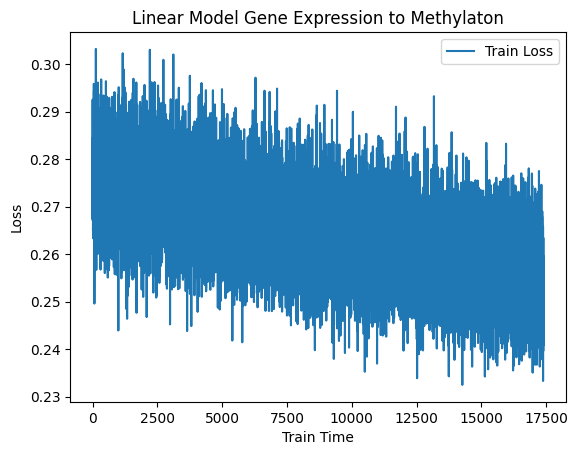

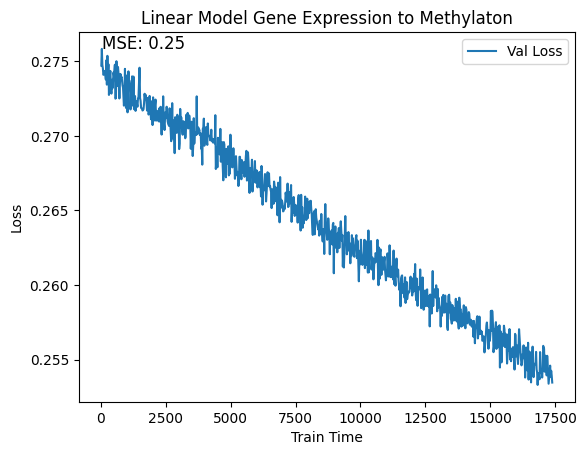

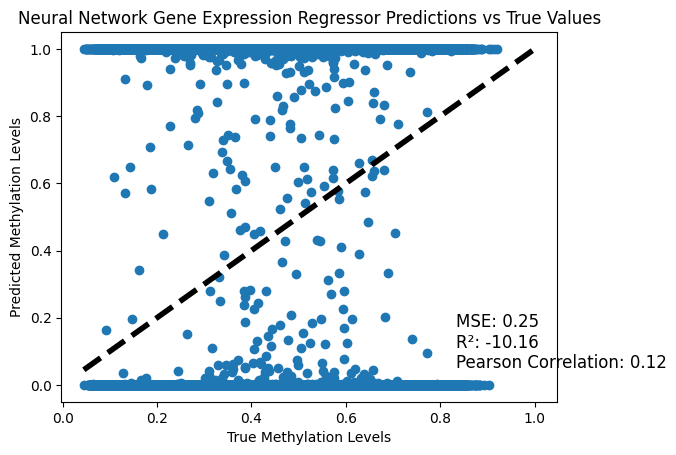

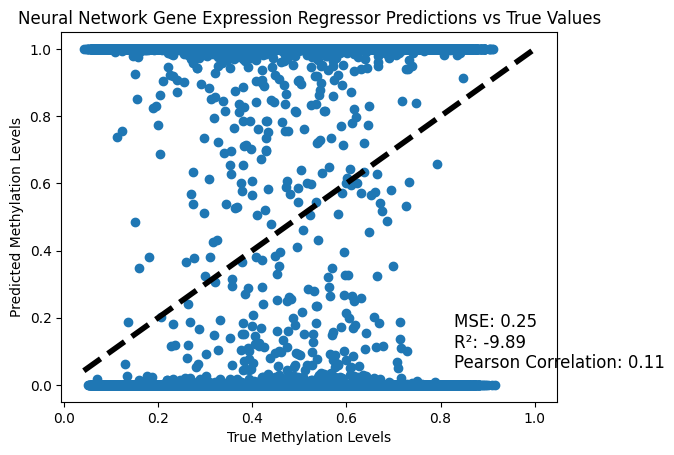

In [24]:
# Iterate over all combinations
results = []
for epoch in epochs:
    for lr in learning_rates:
        for kl_weight in kl_weights:
            for batch_size in batch_sizes:
                print(
                    f"Training with lr={lr}, kl_weight={kl_weight}, batch_size={batch_size}, epochs={epoch}"
                )
                (
                    train_losses,
                    val_losses,
                    last_val_loss,
                    model,
                    valloader,
                    trainloader,
                ) = train_model(
                    lr,
                    kl_weight,
                    batch_size,
                    input_size,
                    output_size,
                    num_epochs=epoch,
                    val_every=20,
                )
                plot_losses(train_losses, val_losses, last_val_loss)
                pred_vs_actual(model, valloader)
                pred_vs_actual(model, trainloader)
                results.append(
                    {
                        "lr": lr,
                        "kl_weight": kl_weight,
                        "batch_size": batch_size,
                        "epoch": epoch,
                        "val_loss": last_val_loss.item(),
                        "model": model,
                    }
                )